# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment


In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name] 

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
env_info = env.reset(train_mode=True)[brain_name]

state_size=env_info.vector_observations.shape[1]
action_size=brain.vector_action_space_size

In [4]:
import torch
import time
import numpy as np
from collections import deque
from multi_agents import MultiAgents

import matplotlib.pyplot as plt
%matplotlib inline

NUM_AGENTS=2

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0]) 

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.38993645 -1.5
 -0.          0.          6.83172083  5.99607611 -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        time.sleep(0.01)
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores))) 

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### My work

#### 1. Train the agents

In [7]:
def train_agents(multi_agents,n_episodes):
    all_scores = []
    scores_window = deque(maxlen=100)

    for i_episode in range(1, n_episodes + 1):
        multi_agents.reset()
        # reset the env
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        # print(states.shape)
        scores = np.zeros(NUM_AGENTS)

        # --- for every time step
        while True:
            # -- get actions for all agents (based on their own observations)
            actions = multi_agents.agents_act(states)
            # -- all agents interact with env at the same time
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards   # list [2]
            next_states = env_info.vector_observations
            dones = env_info.local_done  # list [2]
            # -- store the experiments, update agents
            multi_agents.agents_step(states, actions, rewards, next_states, dones)
            states=next_states
            scores += rewards
            if np.any(dones):
                break 

        # record the scores (所有 agent scores 的平均值)
        scores_window.append(np.mean(scores))
        all_scores.append(np.mean(scores))
            
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode>=100 and np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 5,
                                                                                         np.mean(scores_window)))
            torch.save(multi_agents.ddpg_agents[0].actor_local.state_dict(), 'models_v3/agent1_actor.pth')
            torch.save(multi_agents.ddpg_agents[0].critic_local.state_dict(), 'models_v3/agent1_critic.pth')
            torch.save(multi_agents.ddpg_agents[1].actor_local.state_dict(), 'models_v3/agent2_actor.pth')
            torch.save(multi_agents.ddpg_agents[1].critic_local.state_dict(), 'models_v3/agent2_critic.pth')
            break
            
    return scores
    

In [8]:
multi_agents = MultiAgents(state_size, action_size,NUM_AGENTS,seed=7) 

In [9]:
train_socres = train_agents(multi_agents,n_episodes=10000)  

Episode 100	Average Score: -0.00
Episode 200	Average Score: -0.00
Episode 300	Average Score: -0.00
Episode 400	Average Score: -0.00
Episode 500	Average Score: -0.00
Episode 600	Average Score: -0.00
Episode 700	Average Score: -0.00
Episode 800	Average Score: 0.000
Episode 900	Average Score: 0.04
Episode 1000	Average Score: 0.08
Episode 1100	Average Score: 0.08
Episode 1200	Average Score: 0.07
Episode 1300	Average Score: 0.07
Episode 1400	Average Score: 0.07
Episode 1500	Average Score: 0.04
Episode 1600	Average Score: 0.05
Episode 1700	Average Score: 0.05
Episode 1800	Average Score: 0.04
Episode 1900	Average Score: 0.04
Episode 2000	Average Score: 0.03
Episode 2100	Average Score: 0.03
Episode 2200	Average Score: 0.04
Episode 2300	Average Score: 0.04
Episode 2400	Average Score: 0.03
Episode 2500	Average Score: 0.04
Episode 2600	Average Score: 0.03
Episode 2700	Average Score: 0.02
Episode 2800	Average Score: 0.01
Episode 2900	Average Score: 0.02
Episode 3000	Average Score: 0.02
Episode 310

#### Test the agents

In [24]:
def plot_scores(scores,save_name):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.savefig(save_name)
    plt.show() 

In [13]:
def test_agents(multi_agents,file_names,n_episode):
    # load network parameters for trained agents
    multi_agents.ddpg_agents[0].actor_local.load_state_dict(torch.load(file_names['a1']))
    multi_agents.ddpg_agents[1].actor_local.load_state_dict(torch.load(file_names['a2']))

    # interact with env
    score_test=[]
    for i_episode in range(1, n_episode + 1):
        # reset
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(NUM_AGENTS)

        while True:
            # -- get actions for all agents (based on their own observations)
            actions = multi_agents.agents_act(states)
            # -- all agents interact with env at the same time
            env_info = env.step(actions)[brain_name]
            time.sleep(0.01)
            rewards = env_info.rewards  # list [2]
            next_states = env_info.vector_observations
            dones = env_info.local_done  # list [2]
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        score_test.append(np.mean(scores))
        
    return score_test 

In [21]:
file_names={'a1':'models_v2/agent1_actor.pth','a2':'models_v2/agent2_actor.pth'}  
scores_test=test_agents(multi_agents,file_names,150)   

Episode 100	Average Score: 0.10
Episode 150	Average Score: -0.00

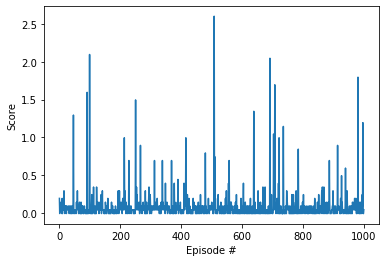

In [20]:
plot_scores(scores_test,"test_1.png")   